# Dataset Recommendation through DOC2VEC

## Objective: 

This notebook explores the feasibility of building a recommendation system for Kaggle Datasets and Users, leveraging the upvote behavior captured in the Meta Kaggle DatasetVotes dataset.

The primary goal is to investigate whether we can generate meaningful suggestions by analyzing user-dataset interactions. Specifically, the system aims to answer two types of recommendation prompts:

- People who liked this dataset also liked...
    - Recommending additional datasets based on the collective preferences of users who upvoted similar datasets.
- You might want to connect with this user...
    - Identifying users with similar interests, based on overlapping voting behavior, to encourage collaboration, learning, or networking.

These recommendations can help:

- Users discover new datasets tailored to their interests.
- Foster community engagement by highlighting like-minded individuals.

![](../assets/images/recommendation_system_upvotes.png)


## Code

### Imports

In [233]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# Faster data operations
import swifter

# Natural Language Processing
import nltk
from nltk.tokenize import word_tokenize

# Document embeddings
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim

# Visualization
import matplotlib.pyplot as plt

# Recommendation system utilities
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# Model utils
from sklearn.model_selection import train_test_split

# Saving utils
import pickle

# System and display
import warnings
import os
from typing import Optional


### Config

In [2]:
warnings.filterwarnings('ignore')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/dhdzmota/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Constants

In [225]:
MODEL_FILEPATH = '../models/doc2vec_model.pkl'

OOT_DATE = '2025-01-01'
RANDOM_SEED = 42
VOTES_THRESHOLD = 5
COMPARISON_THRESHOLD = 0.75

### Read data 

We focused our analysis on three interrelated Kaggle data sources that capture key aspects of dataset publication and interaction within the platform. From the wide range of available tables, we narrowed our scope to those specifically centered on Kaggle Datasets and their usage.

![](../assets/images/dataset_selection.png)

We are working with the following csv files: 

- `archive/DatasetVotes.csv`
- `archive/Datasets.csv`
- `archive/DatasetVersions.csv`

These datasets allow us to explore:

- How datasets are created, owned, and evolved.
- How users interact with datasets via votes.
- How different versions of datasets are managed over time.
---

#### 1. `DatasetVotes`: Core Dataset

This file captures the user engagement with each _dataset_ by tracking votes casted on dataset versions. The main idea is that there is a user-dataset interaction: each user can upvote multiple _datasets_, and each _dataset_ can receive upvotes from multiple users—highlighting a many-to-many relationship between users and _datasets_.
![](../assets/images/user_dataset_interaction.png)

#### 2. `Datasets`: 

This file contains high-level information about each _dataset_ on Kaggle. It basically tracks authorship and ownership, usage statistics, and describes the dataset's nature and lifecycle.
![](../assets/images/datasets_with_information.png)

#### 3. `DatasetVersions`: 

This file tracks each version of a dataset, its description, and title changes over time. This is the main source of information regarding the content of a dataset. 

![](../assets/images/datasets_versions.png)

In [4]:
# Load core datasets
df_datasets = pd.read_csv('../data/archive/Datasets.csv')
df_dataset_votes = pd.read_csv('../data/archive/DatasetVotes.csv')
df_dataset_versions = pd.read_csv('../data/archive/DatasetVersions.csv')

### Functions

In [237]:
def create_user_dataset_relation(df_versions: pd.DataFrame, df_votes: pd.DataFrame) -> pd.DataFrame:
    """
    Create a user-dataset relationship DataFrame by merging DatasetVersions and DatasetVotes.

    Parameters:
    - df_versions (pd.DataFrame): The DatasetVersions DataFrame.
    - df_votes (pd.DataFrame): The DatasetVotes DataFrame.

    Returns:
    - pd.DataFrame: A DataFrame containing DatasetId, CreationDate, UserId, and VoteDate.
    """
    # Rename for clarity and merge
    user_dataset_relation = df_versions.rename(
        columns={'Id': 'DatasetVersionId'}
    )[['DatasetVersionId', 'DatasetId', 'CreationDate']].merge(
        df_votes[['DatasetVersionId', 'UserId', 'VoteDate']],
        on='DatasetVersionId',
        how='right'
    ).drop('DatasetVersionId', axis=1)
    return user_dataset_relation

def create_simplified_dataset(df_datasets: pd.DataFrame, verbose: bool = False) -> pd.DataFrame:
    """
    Create a simplified dataset-user mapping by combining CreatorUserId and OwnerUserId.

    Parameters:
    - df_datasets (pd.DataFrame): The Datasets DataFrame from Meta Kaggle.
    - verbose (bool): Whether to print info about the output DataFrame.

    Returns:
    - pd.DataFrame: A DataFrame with columns ['DatasetId', 'UserId'].
    """
    # Select and rename relevant columns
    simplified = df_datasets[['CreatorUserId', 'OwnerUserId', 'Id']].rename(columns={'Id': 'DatasetId'})
    
    # Combine user fields into a list and explode
    simplified['UserId'] = simplified[['CreatorUserId', 'OwnerUserId']].values.tolist()
    simplified = simplified[['DatasetId', 'UserId']].explode('UserId').dropna()

    # Cast types and drop duplicates
    simplified = simplified.astype({'DatasetId': int, 'UserId': int}).drop_duplicates()
    if verbose:
        print(f"Simplified dataset created. Shape: {simplified.shape}")

    return simplified

def add_user_dataset_identifier(df: pd.DataFrame,
                                dataset_col: str = 'DatasetId',
                                user_col: str = 'UserId',
                                inplace: bool = False) -> pd.DataFrame:
    """
    Adds a combined identifier column (e.g., 'UserId_DatasetId') to a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - dataset_col (str): Name of the dataset ID column. Default is 'DatasetId'.
    - user_col (str): Name of the user ID column. Default is 'UserId'.
    - inplace (bool): Whether to modify the original DataFrame in place.

    Returns:
    - pd.DataFrame: DataFrame with the new identifier column.
    """
    if not inplace:
        df = df.copy()
    new_col = f'{user_col}_{dataset_col}'
    df[new_col] = df[dataset_col].astype(str) + '_' + df[user_col].astype(str)

    return df

def remove_autolikes(user_dataset_df: pd.DataFrame,
                     simplified_dataset_df: pd.DataFrame,
                     id_col: str = 'UserId_DatasetId') -> pd.DataFrame:
    """
    Removes autolikes from the user-dataset interaction DataFrame.
    Autolikes are defined as likes made by the dataset's creator or owner.

    Parameters:
    - user_dataset_df (pd.DataFrame): DataFrame with user-dataset interactions.
    - simplified_dataset_df (pd.DataFrame): DataFrame containing known autolikes based on ownership.
    - id_col (str): Column used to identify user-dataset pairs (default: 'UserId_DatasetId').

    Returns:
    - pd.DataFrame: Filtered DataFrame without autolikes.
    """
    # Ensure copy to avoid modifying original data
    filtered_df = user_dataset_df[~user_dataset_df[id_col].isin(simplified_dataset_df[id_col])].copy()
    
    return filtered_df


def convert_date_to_datetime(df: pd.DataFrame, column: str = 'CreationDate',) -> pd.DataFrame:
    """
    Converts the specified column in a DataFrame to datetime format.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column (str): The name of the column to convert. Default is 'CreationDate'.

    Returns:
    - pd.DataFrame: DataFrame with the converted datetime column.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    df[column] = pd.to_datetime(df[column], errors='coerce')
    return df

def split_user_dataset_by_date(df: pd.DataFrame,
                                date_col: str = 'CreationDate',
                                oot_date: str = '2025-01-01',
                                verbose: bool = True) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits a user-dataset interaction DataFrame into training and OOT sets based on a given date.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the date column.
    - date_col (str): The column name to use for the date filter (default: 'CreationDate').
    - oot_date (str): The out-of-time cutoff date (YYYY-MM-DD format or similar).
    - verbose (bool): Whether to print information about the split.

    Returns:
    - Tuple[pd.DataFrame, pd.DataFrame]: (training_set, oot_set)
    """
    oot_datetime = pd.to_datetime(oot_date)

    df_oot = df[df[date_col] >= oot_datetime].copy()
    df_train = df[df[date_col] < oot_datetime].copy()

    if verbose:
        print(f"Split complete using OOT date: {oot_datetime.date()}")
        print(f"📦 Training set: {df_train.shape[0]} rows")
        print(f"📦 OOT set: {df_oot.shape[0]} rows")

    return df_train, df_oot

def plotting_votes(df: pd.DataFrame,
                      date_col: str = 'VoteDate',
                      title: str = 'Monthly Vote Activity',
                      color: str = 'darkred',
                      alpha: str = 1, 
                      periodicity='M',
                      figsize: tuple = (12, 5),
                  ) -> None:
    """
    Plots the number of rows per month using the specified date column
    to help visually identify outliers or trends.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - date_col (str): The column with datetime values (default: 'VoteDate').
    - title (str): Plot title.
    - color (str): Line color for the plot.
    - figsize (tuple): Size of the figure.
    """
    # Group by month and plot
    grouper = pd.Grouper(key=date_col, freq=periodicity)
    monthly_counts = df.groupby(grouper).size()

    plt.figure(figsize=figsize)
    monthly_counts.plot(color=color, alpha=alpha)
    plt.title(title)
    plt.xlabel(f'Month ({date_col})')
    plt.ylabel('Number of Votes')
    plt.grid(True)
    plt.tight_layout()

def filter_users_by_vote_threshold(df: pd.DataFrame,
                                   user_col: str = 'UserId',
                                   threshold: int = 5,
                                   verbose: bool = True) -> pd.Index:
    """
    Returns user IDs that appear at least 'threshold' times in the DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing user interactions.
    - user_col (str): Name of the column with user IDs.
    - threshold (int): Minimum number of votes required to keep the user.
    - verbose (bool): Whether to print the number of users retained.

    Returns:
    - pd.Index: Index of user IDs that meet or exceed the threshold.
    """
    vote_counts = df[user_col].value_counts()
    usable_users = vote_counts[vote_counts >= threshold].index

    if verbose:
        print(f"{len(usable_users)} users retained with ≥ {threshold} votes.")

    return usable_users

def split_users(user_ids: pd.Index,
                train_size: float = 0.8,
                test_size: float = 0.6,
                random_state: int = 42,
                verbose: bool = True) -> [pd.Index, pd.Index, pd.Index]:
    """
    Splits a list or index of user IDs into train, test, and validation subsets.

    Parameters:
    - user_ids (pd.Index or list): User IDs to split.
    - train_size (float): Proportion of users for the training set (default: 0.8).
    - test_size (float): Proportion of remaining users assigned to the test set (default: 0.6).
    - random_state (int): Random seed for reproducibility.
    - verbose (bool): Whether to print the size of each split.

    Returns:
    - Tuple of pd.Index: (train_users, test_users, val_users)
    """
    # First split: train vs rest
    train_users, rest_users = train_test_split(user_ids, train_size=train_size, random_state=random_state)
    
    # Second split: test vs validation from rest
    test_users, val_users = train_test_split(rest_users, train_size=test_size, random_state=random_state)

    if verbose:
        print(f"User split complete:")
        print(f"   • Train users: {len(train_users)}")
        print(f"   • Test users: {len(test_users)}")
        print(f"   • Validation users: {len(val_users)}")

    return train_users, test_users, val_users

def treatment_function(user_dataset_relation_df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates rolling lists of datasets voted on by users in chronological order.

    This function is designed to generate N-sequence patterns of dataset interactions,
    which can be useful for sequence-based recommendation models.

    Steps:
    1. Sorts the input DataFrame by 'VoteDate'.
    2. For each row, creates a list of the current DatasetId and the N previous ones.
    3. Filters out rows where any of the three dataset IDs are missing (represented by 0).
    4. Returns a simplified DataFrame with the vote timestamp and the triplet of dataset IDs.

    Parameters:
    - user_dataset_relation_df (pd.DataFrame): DataFrame with at least 'VoteDate' and 'DatasetId' columns.

    Returns:
    - pd.DataFrame: A DataFrame with columns:
        • 'VoteDate': Timestamp of the current vote.
        • 'dataset_id': List containing [..., DatasetId_t-2, DatasetId_t-1, DatasetId_t]
          where t is the current row, representing a rolling interaction window.
    """
    # Step 1: Sort by vote timestamp
    sorted_df = user_dataset_relation_df.sort_values('VoteDate')

    # Step 2: Create rolling dataset triplets
    dataset_ids_threshold = []
    for nb_count in range(VOTES_THRESHOLD-1):
        col = f'DatasetId{nb_count+1}'
        dataset_ids_threshold.append(col)
        sorted_df[col] = sorted_df['DatasetId'].shift(nb_count+1).fillna(0).astype(int)
    sorted_df['dataset_id'] = sorted_df[['DatasetId'] + dataset_ids_threshold].values.tolist()

    # Step 3: Remove triplets that contain a placeholder (0) from padding
    filtered_df = sorted_df[~sorted_df['dataset_id'].apply(lambda x: 0 in x)]

    # Step 4: Keep only the necessary columns
    final_df = filtered_df[['VoteDate', 'dataset_id']]

    return final_df

def check_if_file_exists(filepath: str) -> bool:
    """
    Checks whether a file exists at the given path.

    Parameters:
    - filepath (str): The path to the file.
    Returns:
    - bool: True if the file exists, False otherwise.
    """
    exists = os.path.exists(filepath)
    
    return exists

def save_pickle_model(model_object, filepath: str, verbose: bool = True) -> None:
    """
    Saves a Python object (e.g., a model) to disk using pickle.

    Parameters:
    - model_object: The object to save (e.g., trained model).
    - filepath (str): File path where the object will be saved.
    - verbose (bool): If True, prints a success message.

    Returns:
    - None
    """
    with open(filepath, 'wb') as f:
        pickle.dump(model_object, f)
    if verbose:
        print(f"💾 Model successfully saved to: {filepath}")

def load_pickle_model(filepath: str, verbose: bool = True):
    """
    Loads a Python object from a pickle file.

    Parameters:
    - filepath (str): Path to the pickle file.
    - verbose (bool): If True, prints status messages.

    Returns:
    - The loaded Python object.

    Raises:
    - FileNotFoundError: If the file does not exist.
    - Exception: For any other loading issues.
    """
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    if verbose:
        print(f"✅ Model successfully loaded from: {filepath}")
    return model

def infer_vector_from_doc(doc: str, model: Optional[Doc2Vec] = None) -> Optional[np.ndarray]:
    """
    Infers a document vector from raw text using a trained Doc2Vec model.

    Parameters:
    - doc (str): Input document as a raw string.
    - model (Doc2Vec, optional): A trained Gensim Doc2Vec model.

    Returns:
    - np.ndarray or None: The inferred vector if successful, otherwise None.
    """
    if model is not None:
        tokens = word_tokenize(doc.lower())
        vector = model.infer_vector(tokens)
        return vector
    return None

def save_parquet_file(df: pd.DataFrame,
                      set_name: str = 'train',
                      output_dir: str = './',
                      verbose: bool = True) -> None:
    """
    Saves a given DataFrame to a Parquet file with the specified set name.

    Parameters:
    - df (pd.DataFrame): The DataFrame to save.
    - set_name (str): A name indicating the purpose of the file (e.g., 'train', 'test').
    - output_dir (str): Directory where the file will be saved.
    - verbose (bool): If True, prints confirmation of the saved file.

    Returns:
    - None
    """
    # Construct file path
    filepath = os.path.join(output_dir, f"{set_name}.parquet")
    # Save file
    df.to_parquet(filepath)

    if verbose:
        print(f"💾 File saved as: {filepath}")

def plot_ridgeline(df, group_col, value_col,
                               bandwidth=0.02,
                               figsize=(10, 6),
                               alpha=0.6,
                               spacing=1.0,
                               ylabel='',
                               color='darkred',
                               title='Ridgeline Plot'):
    """
    Creates a ridgeline (stacked KDE) plot using only matplotlib.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - group_col (str): Column to group by (e.g. 'jaccard_distance').
    - value_col (str): Column with values to plot (e.g. 'cos_similarity').
    - bandwidth (float): Smoothing bandwidth for KDE.
    - figsize (tuple): Size of the figure.
    - alpha (float): Transparency of each curve.
    - spacing (float): Vertical offset between curves.
    - color (str): Color of the KDE curves.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=figsize)

    unique_groups = sorted(df[group_col].dropna().unique(), reverse=True)
    x_grid = np.linspace(0, 1, 100)

    for i, group in enumerate(unique_groups):
        data = df[df[group_col] == group][value_col].dropna()
        kde = gaussian_kde(data, bw_method=bandwidth)
        y = kde(x_grid)
        y = y / y.max()  # Normalize
        offset = i * spacing
        plt.fill_between(x_grid, y + offset, offset, alpha=alpha, color=color)
        plt.text(1.01, offset, str(group), va='center', fontsize=9)

    plt.title(title)
    plt.xlabel(value_col)
    plt.yticks([])
    plt.ylabel(ylabel)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

### Process data

#### Joining Users and Datasets via Votes

To analyze user-dataset interactions, we need to connect users with the datasets they've upvoted. However, the df_dataset_votes table records votes at the version level, not directly at the dataset level. To bridge this, we use df_dataset_versions, which maps each version to its corresponding dataset.

In this analysis, we make the simplifying assumption that each vote corresponds to the latest version of the dataset. While a more accurate approach would align votes with the dataset version closest in time, this simplification allows us to focus on broader engagement patterns without complex temporal alignment.
```
Note: This is a trade-off between accuracy and practicality. Future iterations could refine this by matching vote timestamps to the nearest version date.
```

In [6]:
user_dataset_relation = create_user_dataset_relation(
    df_versions=df_dataset_versions, df_votes=df_dataset_votes
)

In [7]:
simplified_dataset = create_simplified_dataset(df_datasets, verbose=True)

Simplified dataset created. Shape: (489863, 2)


In [8]:

simplified_dataset = add_user_dataset_identifier(simplified_dataset)
user_dataset_relation = add_user_dataset_identifier(user_dataset_relation)


#### Remove Auto-Likes (Self-Upvotes)

Another important preprocessing step is filtering out auto-likes, or self-upvotes. These occur when the creator or owner of a dataset upvotes their own work — a form of artificial inflation that can bias our analysis.

To address this:
- Each dataset includes a CreatorUserId and an OwnerUserId.
- We remove any vote where the UserId (the one who voted) matches either the CreatorUserId or OwnerUserId of the corresponding dataset.

By excluding these self-upvotes, we ensure that the engagement metrics better reflect organic community interaction, rather than actions taken by the dataset authors themselves.



In [9]:
user_dataset_relation = remove_autolikes(user_dataset_relation, simplified_dataset)

In [10]:
user_dataset_relation = convert_date_to_datetime(user_dataset_relation, column='CreationDate')
user_dataset_relation = convert_date_to_datetime(user_dataset_relation, column='VoteDate')

#### Detecting and Removing Voting Outliers

To ensure that our analysis reflects genuine engagement, we need to address the presence of outlier users: those whose voting behavior appears unnatural or automated.

We consider two types of outliers:

1. High-Volume Voters
Some users upvote an abnormally large number of datasets. While most users upvote just one, a few have voted on over 100,000 datasets, which strongly suggests automated or non-organic behavior.

2. High-Speed Voters
Beyond volume, some users vote at unrealistically high speeds (Users with a high number of votes over a short period (e.g., hundreds per hour or more) are likely automated). For this, we calculate the vote rate by analyzing:
    - The total number of upvotes.
    - The time span between their first and last recorded upvote.


##### Strategy: 
We define a threshold (e.g., the 99.975th percentile as a hard cutoff) and exclude users who have upvoted more datasets than that threshold in both speed and high volume. 

By filtering out both high-volume and high-speed voters, we ensure that the remaining data better represents authentic, human interactions with datasets.



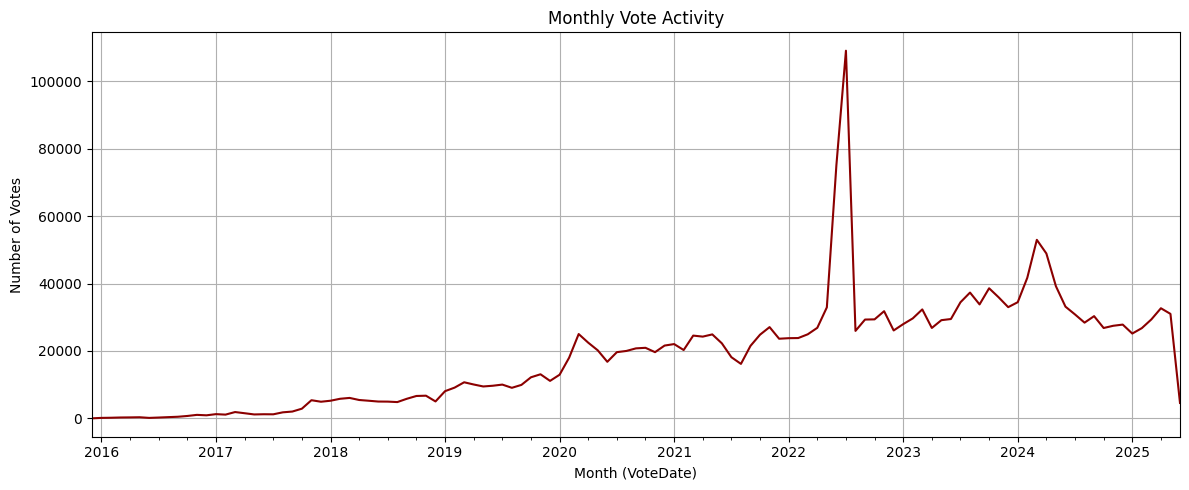

In [11]:
plotting_votes(user_dataset_relation)

In [12]:
user_votes_speed = user_dataset_relation.groupby('UserId').agg(
    vote_date_max=('VoteDate', 'max'),
    vote_date_min=('VoteDate', 'min'),
    vote_count=('VoteDate', 'count')
)
count_of_votes = user_dataset_relation.UserId.value_counts()
speed_of_votes = (user_votes_speed.vote_count/((user_votes_speed.vote_date_max-user_votes_speed.vote_date_min).dt.days+1)).sort_values(ascending=False)

In [13]:
# Based on the intersection speed of the votes and the amount of votes given a quantile, outliers were taken out. 
quantile = 0.99975
outliers = speed_of_votes.loc[
    list(
        set(count_of_votes[count_of_votes>count_of_votes.quantile(quantile)].index).intersection(
            set(speed_of_votes[speed_of_votes>speed_of_votes.quantile(quantile)].index)
        )
    )
].index

In [14]:
# Finding outliers:
user_dataset_relation_outlier = user_dataset_relation[(user_dataset_relation.UserId.isin(outliers))]
user_dataset_relation = user_dataset_relation[~(user_dataset_relation.UserId.isin(outliers))]

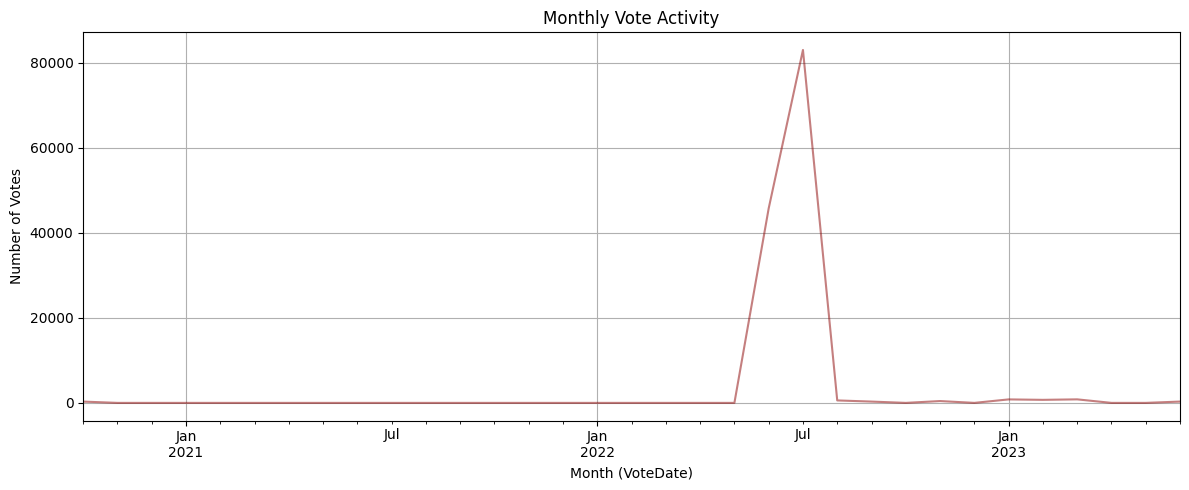

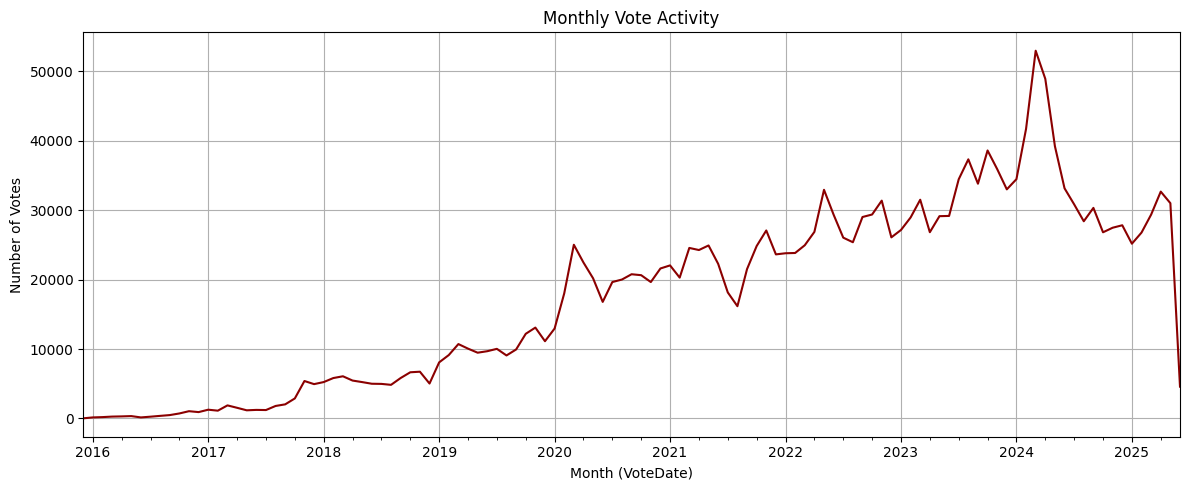

In [15]:
plotting_votes(user_dataset_relation_outlier, alpha=0.5, periodicity='M')
plotting_votes(user_dataset_relation, alpha=1)

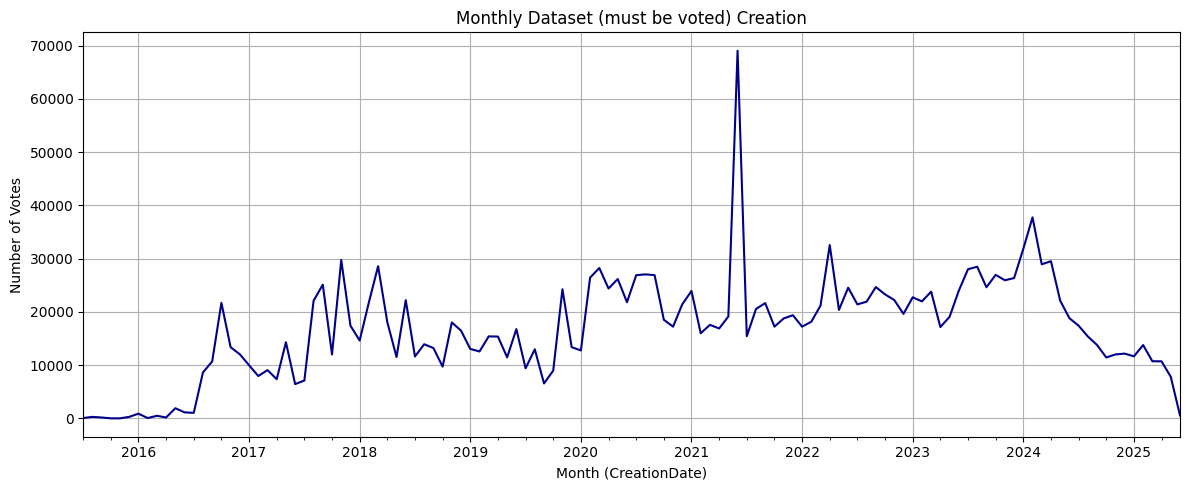

In [16]:
plotting_votes(user_dataset_relation, date_col='CreationDate', color='darkblue', title='Monthly Dataset (must be voted) Creation')

#### Filtering for Recent Datasets

To ensure our analysis and recommendations reflect current trends and data usage patterns, we limit our scope to datasets created from 2020 onward.

This temporal filtering helps:
- Maintain relevance with respect to modern data practices and topics.
- Avoid outdated datasets that may no longer be available, supported, or used.
- Reduce noise from legacy content with inconsistent metadata formats.


In [17]:
user_dataset_relation = user_dataset_relation[user_dataset_relation.CreationDate >= pd.to_datetime('2020-01-01')]

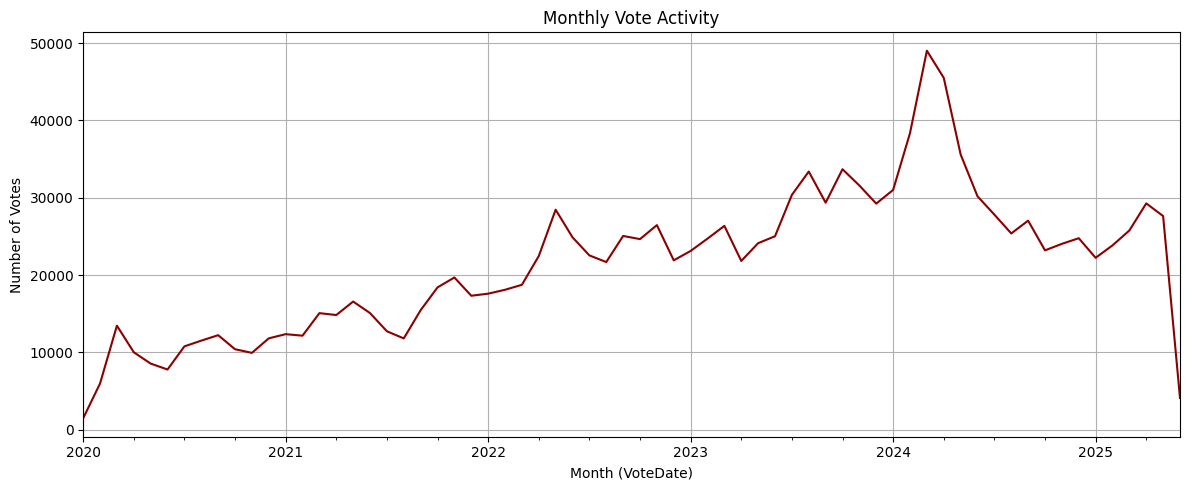

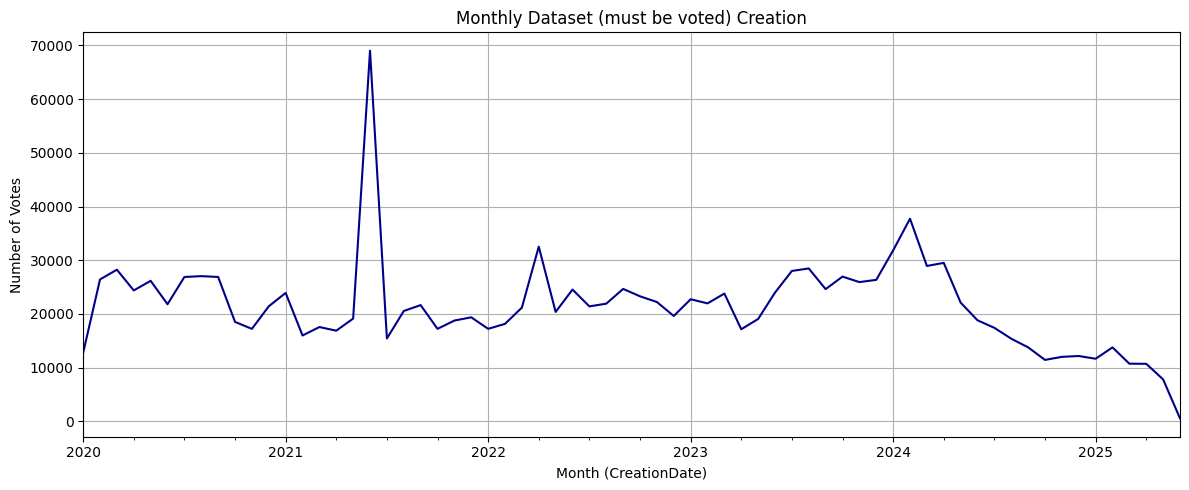

In [18]:
plotting_votes(user_dataset_relation)
plotting_votes(user_dataset_relation, date_col='CreationDate', color='darkblue', title='Monthly Dataset (must be voted) Creation')

#### Definition of a Document

For the purpose of this recommendation system, we define a document as the textual representation of a dataset based on its core descriptive fields. Specifically, each document is constructed using the following:

- `Title`: The main name of the dataset.
- `Subtitle`: A brief complementary description, often used to add context or highlight use cases.
- `Description`: A more detailed explanation of the dataset’s content, structure, and intended purpose.

These three fields are concatenated to form a single text unit that serves as the semantic representation of the dataset. This approach enables us to capture the internal linguistic structure and thematic relationships between words and phrases, which are crucial for modeling dataset similarity and relevance in a content-based recommendation system.

This document definition is foundational for later stages.

In [19]:
# Lets get a intial treatment of the dataset versions
df_dataset_versions['TotalDescription'] = (
    df_dataset_versions.Title.fillna('') + ' ' + 
    df_dataset_versions.Subtitle.fillna('') + ' ' +
    df_dataset_versions.Description.fillna('') 
)

### Data splitting

#### Temporal Holdout

To ensure consistency with a realistic evaluation setting, we perform a time-based data split. This helps simulate a real-world scenario where future data is unknown at training time.

- Training Window:
From `2020-01-01` to `2025-01-01` (inclusive).
This 5-year span represents the data available during the system’s training phase.

- Out-of-Time (OOT) Evaluation Window:
From `2025-01-01` onward.
This portion is reserved for testing and evaluation, simulating how the system performs on unseen, future datasets.

This approach ensures:
- No data leakage from future to past.
- Fair assessment of generalization capabilities.
- Chronological integrity, which is especially important in recommendation systems where content freshness and recency matter.

In [20]:
user_dataset_relation_t, user_dataset_relation_oot = split_user_dataset_by_date(
    user_dataset_relation, oot_date=OOT_DATE
)

Split complete using OOT date: 2025-01-01
📦 Training set: 1359910 rows
📦 OOT set: 55163 rows


#### User Selection Criteria

We apply a user filtering rule to ensure fairness and meaningful participation: 

__Only users who have upvoted at least 5 different datasets are included in the analysis.__

![](../assets/images/user_selection_criteria.png)

This criterion helps us:
- Eliminate accounts with minimal activity (e.g., 1,2, 3 and 4 upvotes), which may introduce noise.
- Focus on users with a more representative engagement history.
- Make fairer evaluations when assessing recommendations across users.

In [21]:
# We apply the votes threshold for each users.
actual_usable_users = filter_users_by_vote_threshold(
    user_dataset_relation_t, threshold=VOTES_THRESHOLD
)

actual_usable_users_oot = filter_users_by_vote_threshold(
    user_dataset_relation_oot, threshold=VOTES_THRESHOLD
)

23739 users retained with ≥ 5 votes.
1183 users retained with ≥ 5 votes.


#### Random Split for Train Window

To effectively evaluate and refine our model's performance, we adopted a systematic user-based data splitting approach, ensuring that no user appears in more than one split. This helps preserve the integrity of our evaluation process.


- **Training Set** (80%)
80% of the eligible users were randomly assigned to the training set. This subset is used to build and optimize the model.

- **Validation Set** (12%)
60% of the remaining 20% was allocated to validation. This set is used during development to tune model hyperparameters and prevent overfitting.

- **Test Set** (8%)
The final 40% of the 20% holdout is reserved for final evaluation, ensuring an unbiased measure of model performance.

By performing random user-based splits, we avoid data leakage across sets while creating a robust and generalizable training environment. This strategy also enables fair benchmarking across different modeling strategies and evaluation rounds.

In [263]:
train_users, test_users, val_users = split_users(actual_usable_users, random_state=RANDOM_SEED)

User split complete:
   • Train users: 18991
   • Test users: 2848
   • Validation users: 1900


In [23]:
# Current datasets
user_dataset_relation_t__train = user_dataset_relation_t[user_dataset_relation_t.UserId.isin(train_users)]
user_dataset_relation_t__test = user_dataset_relation_t[user_dataset_relation_t.UserId.isin(test_users)]
user_dataset_relation_t__val = user_dataset_relation_t[user_dataset_relation_t.UserId.isin(val_users)]

# Future datsets
user_dataset_relation_oot__train = user_dataset_relation_oot[user_dataset_relation_oot.UserId.isin(train_users)]
user_dataset_relation_oot__test = user_dataset_relation_oot[~user_dataset_relation_oot.UserId.isin(train_users)]

### Data Prepparation

To effectively analyze user behavior and prepare the data for a recommender system, we process historical upvote data into a structured, time-aware format. This enables the model to learn sequential usage patterns across datasets.


We begin by sorting the dataset by the VoteDate column to maintain a chronological order of user interactions.

For each user, we build rolling interaction windows of size 5:
- The first 4 entries are treated as historical context (previously upvoted datasets).
- The 6th entry is the current dataset being upvoted.

This forms the basis for predicting future dataset interests based on past behavior.

Any sequence where fewer than 5 prior datasets are available is excluded to ensure consistency and completeness in training data.

The resulting DataFrame contains:
- The VoteDate (timestamp of the current upvote),
- The 5 historical DatasetIds (used as input),

 Note: A single user may contribute multiple sequences over time. Each sequence is independent, even if they come from the same user, allowing for rich temporal modeling.

![](../assets/images/data_prep.png)

In [24]:
agg__user_dataset_relation_t__train = user_dataset_relation_t__train.groupby('UserId').apply(treatment_function)
agg__user_dataset_relation_t__test = user_dataset_relation_t__test.groupby('UserId').apply(treatment_function)
agg__user_dataset_relation_t__val = user_dataset_relation_t__val.groupby('UserId').apply(treatment_function)
agg__user_dataset_relation_oot__train = user_dataset_relation_oot__train.groupby('UserId').apply(treatment_function)
agg__user_dataset_relation_oot__test = user_dataset_relation_oot__test.groupby('UserId').apply(treatment_function)

In [25]:
all_train_dataset_ids = agg__user_dataset_relation_t__train.reset_index().drop('level_1', axis=1).explode('dataset_id').dataset_id.unique()
all_test_dataset_ids = agg__user_dataset_relation_t__test.reset_index().drop('level_1', axis=1).explode('dataset_id').dataset_id.unique()
all_val_dataset_ids = agg__user_dataset_relation_t__val.reset_index().drop('level_1', axis=1).explode('dataset_id').dataset_id.unique()

In [26]:
# These might appear in the training set
all_train_datasets = df_dataset_versions[df_dataset_versions.DatasetId.isin(all_train_dataset_ids)].sort_values('VersionNumber').groupby('DatasetId').TotalDescription.last()
# This is just for training the doc2vec model without duplicates
all_train_datasets_unique = all_train_datasets.drop_duplicates().dropna()

In [27]:
all_test_datasets = df_dataset_versions[df_dataset_versions.DatasetId.isin(all_test_dataset_ids)].sort_values('VersionNumber').groupby('DatasetId').TotalDescription.last()
all_test_datasets_unique = all_test_datasets.drop_duplicates().dropna()

all_val_datasets = df_dataset_versions[df_dataset_versions.DatasetId.isin(all_val_dataset_ids)].sort_values('VersionNumber').groupby('DatasetId').TotalDescription.last()
all_val_datasets_unique = all_val_datasets.drop_duplicates().dropna()

### Model training

#### Training the Doc2Vec Model

Understanding user preferences and dataset relationships requires a way to represent dataset content numerically. To achieve this, we use Doc2Vec, a deep learning–based algorithm that converts textual documents into dense vector representations capturing semantic meaning.

We trained the Doc2Vec model using dataset documents from the user training set. As stated before, each document is a combination of the following fields:

- Title.
- Subtitle.
- Description.
  
This combined text serves as a rich source of semantic information about each dataset.


##### Model Parameters
a. **Vector Size (128)**: Dimensionality of the generated vectors. Higher values allow the model to capture more subtle relationships.

b. **Min Count (8)**: Words that appear fewer than 8 times are ignored, helping reduce noise and focus on meaningful terms.

c. **Epochs (50)**: The number of full passes through the training data. More epochs enable the model to learn complex patterns.


##### Model Training Workflow

1. **Tokenization**: Each document is split into words, following standard preprocessing (e.g., lowercasing, punctuation removal).


2. **Dataset Preparation**: The tokenized documents form
the input for training the Doc2Vec model.

3. **Model Training**: The model learns to associate each document with a fixed-length vector that captures its semantic essence.

4. **Model Application**: The trained Doc2Vec model is then
applied to each document of a set. Each document is individually transformed into a vector representation.

This representation allows for nuanced comparisons between datasets, forming the foundation for the recommender system’s ability to suggest relevant content based on textual similarity.

In [28]:
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(all_train_datasets_unique)]

In [232]:
if not check_if_find_exists(MODEL_FILEPATH):
    model = Doc2Vec(vector_size=128, min_count=8, epochs=50)
    model.random.seed(RANDOM_SEED)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    save_pickle_model(model, MODEL_FILEPATH)
else:
    model = load_pickle_model(MODEL_FILEPATH)

✅ Model successfully loaded from: ../models/doc2vec_model.pkl


In [31]:
all_train_datasets_embeddings = all_train_datasets.fillna('No description available.').swifter.apply(infer_vector_from_doc, model=model)

Pandas Apply:   0%|          | 0/83828 [00:00<?, ?it/s]

In [32]:
all_test_datasets_embeddings = all_test_datasets.fillna('No description available.').swifter.apply(infer_vector_from_doc, model=model)

Pandas Apply:   0%|          | 0/25918 [00:00<?, ?it/s]

In [33]:
all_val_datasets_embeddings = all_val_datasets.fillna('No description available.').swifter.apply(infer_vector_from_doc, model=model)

Pandas Apply:   0%|          | 0/21243 [00:00<?, ?it/s]

#### Feature computation

Once all dataset documents in the training, validation, and test sets are transformed into vector representations using the trained Doc2Vec model, we can proceed to summarize user behavior.

Each user instance includes five historical datasets they previously upvoted. To capture the essence of a user's past preferences, we apply a simple yet effective aggregation technique:

We compute the mean of the five document normalized embeddings associated with each user instance.

This aggregation produces a single vector that serves as a representation of the user's recent interests and interactions, which can then be compared to candidate dataset vectors during recommendation.

![](../assets/images/feature_computation.png)

In this case, the aggregation has the following perks:
- Simplicity: Easy to compute and interpret.
- Effectiveness: Averages the semantic signals across multiple documents.
- Order-Invariance: Assumes no temporal weighting (each historical dataset is treated equally).

In [35]:
agg__user_dataset_relation_w_embeddings_t__train = agg__user_dataset_relation_t__train.dataset_id.explode().reset_index().merge(
    all_train_datasets_embeddings.apply(lambda x: x/np.linalg.norm(x)).reset_index(), 
    left_on='dataset_id',
    right_on='DatasetId', 
    how='left',
).groupby(['UserId','level_1']).TotalDescription.mean()

In [36]:
agg__user_dataset_relation_w_embeddings_t__test = agg__user_dataset_relation_t__test.dataset_id.explode().reset_index().merge(
    all_test_datasets_embeddings.apply(lambda x: x/np.linalg.norm(x)).reset_index(), 
    left_on='dataset_id',
    right_on='DatasetId', 
    how='left',
).groupby(['UserId','level_1']).TotalDescription.mean()

In [37]:
agg__user_dataset_relation_w_embeddings_t__val = agg__user_dataset_relation_t__val.dataset_id.explode().reset_index().merge(
    all_val_datasets_embeddings.apply(lambda x: x/np.linalg.norm(x)).reset_index(), 
    left_on='dataset_id',
    right_on='DatasetId', 
    how='left',
).groupby(['UserId','level_1']).TotalDescription.mean()

#### Saving information

After this is done for user instance, the resulting vectors are saved for downstream tasks.

In [38]:
agg__user_dataset_relation_t__train['embeddings'] = agg__user_dataset_relation_w_embeddings_t__train.apply(lambda x: x/np.linalg.norm(x))

In [238]:
save_parquet_file(agg__user_dataset_relation_t__train, set_name='train', output_dir='../data/processed/')

💾 File saved as: ../data/processed/train.parquet


In [39]:
agg__user_dataset_relation_t__test['embeddings'] = agg__user_dataset_relation_w_embeddings_t__test.apply(lambda x: x/np.linalg.norm(x))

In [239]:
save_parquet_file(agg__user_dataset_relation_t__test, set_name='test', output_dir='../data/processed/')

💾 File saved as: ../data/processed/test.parquet


In [40]:
agg__user_dataset_relation_t__val['embeddings'] = agg__user_dataset_relation_w_embeddings_t__val.apply(lambda x: x/np.linalg.norm(x))

In [240]:
save_parquet_file(agg__user_dataset_relation_t__val, set_name='val', output_dir='../data/processed/')

💾 File saved as: ../data/processed/val.parquet


### Checking model performance

In [160]:
results = {}
for row in agg__user_dataset_relation_t__val.sample(frac=0.1).iterrows():
    index, row_characteristics = row
    t = agg__user_dataset_relation_t__test.embeddings.apply(lambda x: (x * row_characteristics.embeddings).sum()).sort_values()
    results[index] = t

ERROR! Session/line number was not unique in database. History logging moved to new session 145


In [162]:
len(results)

3332

In [165]:
results_df = pd.DataFrame(results)

In [193]:
results_answers = pd.DataFrame()

In [194]:
results_answers['id_max_test'] = results_df.idxmax()

In [195]:
results_answers['dataset_id_val'] = agg__user_dataset_relation_t__val.loc[results_df.columns].dataset_id

In [196]:
results_answers['dataset_id_test'] = agg__user_dataset_relation_t__test.loc[results_df.idxmax().to_list()].dataset_id.to_list()

In [197]:
results_answers['cos_similarity'] = results_df.max()

In [204]:
def jaccard_distance_df(df):
    a = df.dataset_id_val
    b = df.dataset_id_test
    len_a = len(a)
    len_b = len(b)
    len_intersection = len(set(a).intersection(set(b)))
    distance = len_intersection/(len_a + len_b)
    return distance

In [205]:
results_answers['jaccard_distance'] = results_answers.apply(jaccard_distance_df, axis=1)

In [214]:
def plot_hist(series):
    plt.hist(series, bins=np.linspace(0,1,100))
    return series.describe()

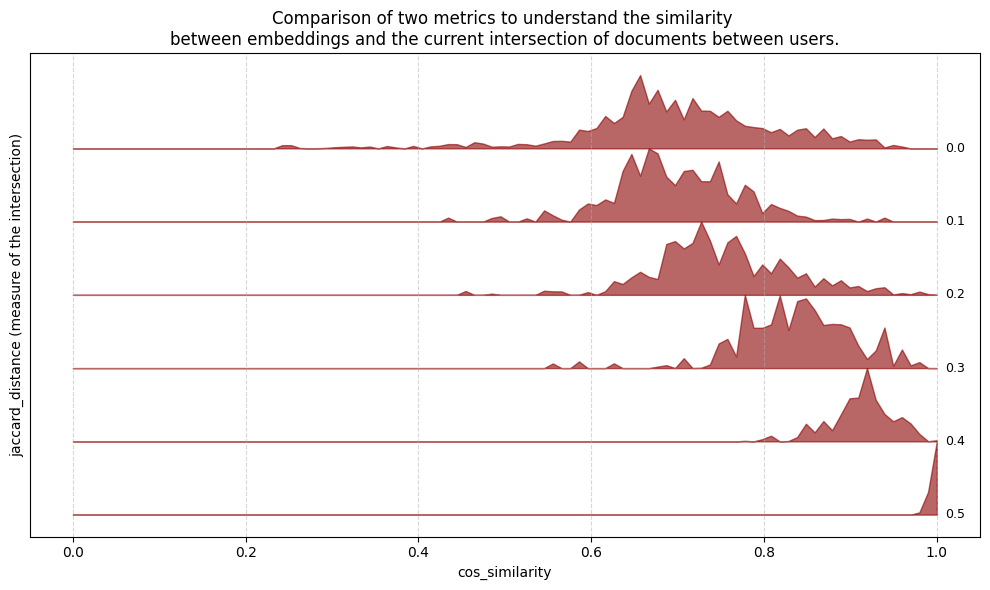

In [251]:
title="""Comparison of two metrics to understand the similarity 
between embeddings and the current intersection of documents between users."""

plot_ridgeline(
    results_answers,
    group_col='jaccard_distance', 
    value_col='cos_similarity', 
    ylabel='jaccard_distance (measure of the intersection)',
    title=title
)


From the analysis, we observe the following relationship between cosine similarity and Jaccard distance:

When cosine similarity is below 0.65, it's very likely that no intersection exists between the sets (i.e., Jaccard Distance = 0).

When cosine similarity is between 0.6 and 0.8, the probability of at least some intersection (e.g., Jaccard Distance = 0.1) increases significantly.

Once cosine similarity reaches 0.74 or higher, the amount of shared elements tends to rise more consistently.

In general, as cosine similarity increases, the intersection between sets (i.e., similarity in content) becomes more substantial and reliable.

#### Recommendation Strategy
A useful recommendation arises when two datasets do not intersect (i.e., offer diverse content) but still maintain a relatively high cosine similarity—this suggests semantic alignment without redundancy.

Recommending fully overlapping datasets is not particularly useful, as their similarity is expected and adds little value.

Therefore, we propose focusing on dataset pairs with cosine similarity between 0.75 and 0.9, where the intersection is minimal (at most 3 documents), but semantic alignment is strong.

In scenarios where no high similarity scores exist, it may not be possible to generate a meaningful recommendation.

This balance between semantic similarity and element diversity is key to generating effective and novel recommendations.

In [41]:
# Manually check if recommendations work:

In [43]:
# Step 1: select a random sample from any set, in this case validation
random_sample = agg__user_dataset_relation_t__val.sample(1)

# Step 2: if its the same set, remove the user from the set so comparisons are not made for the same user.
try:
    new_agg__user_dataset_relation_t__val = agg__user_dataset_relation_t__val.drop(random_sample.index[0])
except:
    pass
new_agg__user_dataset_relation_t__val

# Step 3: Make a comparison of all the embeddings with the random sampled embedding
embedding_comparison = new_agg__user_dataset_relation_t__val.embeddings.swifter.apply(
    lambda x: (x * random_sample.iloc[0].embeddings).sum()
).sort_values()

# Compare and contrast
random_sample_list = agg__user_dataset_relation_t__val.loc[random_sample.head(1).index]
random_sample_list = random_sample_list.dataset_id.iloc[0]

comparison_sample_list_worst = agg__user_dataset_relation_t__val.loc[embedding_comparison[embedding_comparison > COMPARISON_THRESHOLD].head(1).index]
comparison_sample_list_best = agg__user_dataset_relation_t__val.loc[embedding_comparison[embedding_comparison > COMPARISON_THRESHOLD].tail(1).index]

comparison_sample_list_worst = comparison_sample_list_worst.dataset_id.iloc[0]
comparison_sample_list_best = comparison_sample_list_best.dataset_id.iloc[0]

Pandas Apply:   0%|          | 0/33324 [00:00<?, ?it/s]

In [44]:
intersection_worst = set(comparison_sample_list_worst).intersection(random_sample_list)
intersection_best = set(comparison_sample_list_best).intersection(random_sample_list)

In [45]:
print(set(comparison_sample_list_worst).symmetric_difference(random_sample_list))
print(set(comparison_sample_list_best).symmetric_difference(random_sample_list))

{4387809, 4394947, 4394092, 4396590}
{4397070, 4391355}


In [46]:
set(comparison_sample_list_best).symmetric_difference(random_sample_list)

{4391355, 4397070}

In [47]:
df_dataset_versions[
    df_dataset_versions.DatasetId.isin(intersection_worst)
].sort_values(
    'VersionNumber'
).drop_duplicates(
    'DatasetId', keep='last'
).set_index(
    'DatasetId'
)[['Title', 'Slug', 'Subtitle', 'Description']]

,Title,Slug,Subtitle,Description
DatasetId,,,,
4397070,local dataset,local-dataset,NaN,NaN
4393990,Well_water,well-water,NaN,NaN
4387630,MegaStore Sales Data,megastore-sales-data,Retail Sales Dataset: Two-Year Record of Trans...,This dataset spans a period of thirteen months...


In [48]:
df_dataset_versions[
    df_dataset_versions.DatasetId.isin(comparison_sample_list_worst)
].sort_values(
    'VersionNumber'
).drop_duplicates(
    'DatasetId', keep='last'
).set_index(
    'DatasetId'
)[['Title', 'Slug', 'Subtitle', 'Description']].drop(intersection_worst)

,Title,Slug,Subtitle,Description
DatasetId,,,,
4394947,"Connectionist Bench (Sonar, Mines vs. Rocks)",connectionist-bench-sonar-mines-vs-rocks,NaN,NaN
4394092,images,images,Image for food and non food,NaN


In [49]:
df_dataset_versions[
    df_dataset_versions.DatasetId.isin(random_sample_list)
].sort_values(
    'VersionNumber'
).drop_duplicates(
    'DatasetId', keep='last'
).set_index(
    'DatasetId'
)[['Title', 'Slug', 'Subtitle', 'Description']].drop(intersection_worst)

,Title,Slug,Subtitle,Description
DatasetId,,,,
4387809,tokens,tokens,NaN,NaN
4396590,generalization_text_03M_largeV3Deberta,generalization-text-03m-largev3deberta,NaN,NaN


In [50]:
df_dataset_versions[
    df_dataset_versions.DatasetId.isin(comparison_sample_list_best)
].sort_values(
    'VersionNumber'
).drop_duplicates(
    'DatasetId', keep='last'
).set_index(
    'DatasetId'
)[['Title', 'Slug', 'Subtitle', 'Description']].drop(intersection_best)

,Title,Slug,Subtitle,Description
DatasetId,,,,
4391355,CarPlate Detection,carplate-detection,NaN,NaN


In [51]:
df_dataset_versions[
    df_dataset_versions.DatasetId.isin(random_sample_list)
].sort_values(
    'VersionNumber'
).drop_duplicates(
    'DatasetId', keep='last'
).set_index(
    'DatasetId'
)[['Title', 'Slug', 'Subtitle', 'Description']].drop(intersection_best)

,Title,Slug,Subtitle,Description
DatasetId,,,,
4397070,local dataset,local-dataset,NaN,NaN


In [52]:
# Lets test a generic user now...
user_dataset_relation

,DatasetId,CreationDate,UserId,VoteDate,UserId_DatasetId
17125,58,2020-03-01 09:04:29,3218149,2020-03-05,58_3218149
17126,58,2020-04-28 05:27:16,3608062,2020-05-04,58_3608062
17127,58,2020-04-28 05:27:16,4174380,2020-05-01,58_4174380
17128,58,2020-03-27 15:19:09,4727025,2020-04-21,58_4727025
17129,58,2020-08-23 07:50:43,3948536,2020-08-25,58_3948536
...,...,...,...,...,...
2213071,7544631,2025-05-29 10:27:57,27026046,2025-05-29,7544631_27026046
2213072,7545346,2025-05-29 11:56:22,26985119,2025-06-01,7545346_26985119
2213074,7566127,2025-06-01 12:39:16,26744881,2025-06-01,7566127_26744881
2213075,7566127,2025-06-01 12:39:16,4512670,2025-06-01,7566127_4512670


In [153]:
# Given a list of 5 datasets. We need to compute the corresponding embeddings. 
last_version_datasets_resumed = df_dataset_versions[
    (df_dataset_versions.DatasetId.isin(user_dataset_relation.DatasetId.unique())) & 
    (df_dataset_versions.Description.notna())
].sort_values(
    'VersionNumber'
).drop_duplicates(
    'DatasetId', keep='last'
).set_index(
    'DatasetId'
)[['Title', 'Slug', 'Subtitle', 'Description', 'TotalDescription']].sample(5)

embedding_trial = last_version_datasets_resumed.TotalDescription.apply(infer_vector_from_doc, model=model).apply(lambda x: x/np.linalg.norm(x)).mean()

all_datasets = pd.concat([agg__user_dataset_relation_t__val, agg__user_dataset_relation_t__test, agg__user_dataset_relation_t__train], axis=0)

embedding_comparison = all_datasets.embeddings.swifter.apply(
    lambda x: (x* embedding_trial).sum()
).sort_values()
embedding_comparison

Pandas Apply:   0%|          | 0/526085 [00:00<?, ?it/s]

UserId           
3012786   2158991   -0.184779
          2158998   -0.165115
7889039   905002    -0.142950
403809    905003    -0.142950
1496622   872960    -0.139961
                       ...   
8045607   1529331    0.356723
          1529350    0.357886
3012786   1859248    0.358071
6801936   2061969    0.359165
13954148  1604683    0.363242
Name: embeddings, Length: 526085, dtype: float32

In [ ]:
0.3 to 0.4: Best performances given a random sample
0.6 to 0.7

Tenemos un usuario, dicho usuario tiene distintos "likes" a datasets, se contempla el like actual, y además los dos últimos. Independientemente de la fecha. 

En este caso, serían 5 datasets (documentos), que se concatenan y se hace un documento, el cuál se convierte en embedding doc2vec. Una vez se tenga esta información, se procede a tener usuario (con ciertas características), embeddings. 

In [69]:
#!uv pip install torch

In [ ]:
# We need to remove autovotes (if they exist):
# Autovotes are defined as giving upvote to a dataset uploaded by yourself.
